# Set up file 

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
import scipy.interpolate
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Deglaciation/modules/')
from keyname import keyname as kn
import config
from plott import plott
import scipy.interpolate
# from mpl_toolkits.basemap import Basemap
matplotlib.use('agg')
from Cross_section import Cross_section
from Proxy_graph_masked import Proxy_graph
import Config
# from Map_plot import Map_plot
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
from IPython import embed
import os
import ast
from matplotlib import gridspec
import itertools
import xarray as xr
import json

%matplotlib inline

In [2]:
# Set Formatting variables
alpha = 0.5
point_color_dp = (0,0,1,alpha)#'blue'
point_color_shw = (1,0,0,alpha)#'red'
line_color_dp = 'cyan'
line_color_shw = 'magenta'
lw = 4
edgewidth=0.5
size = 40
fontsize = 20

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']


# Load stored results

In [3]:
results_dict = json.loads(open("Data/results_dict.json","r").read())

# Calculate d13C time-depth mv avg

In [4]:
def moving_average_slice_array(df_samples,lat_min,lat_max):
    ################################################
                    # Grid Creation
    ################################################

    # Get a latitudinal slice of the data
    df_samples = df_samples[(df_samples.Lat> lat_min) & (df_samples.Lat < lat_max)]

    # Create depth grid for the data
    depth_range_1 = np.arange(1000,6000,250)
    depth_range_2 = np.arange(1000+100,6000+100,250+100)
    depth_grid = []
    for dep_shw, dep_dp in zip(depth_range_1,depth_range_2):
        depth_grid.append(np.mean([dep_shw,dep_dp]))

    # Create period grid for the data
    period_grid = np.unique(df_samples.age)

    ################################################
                # Determining grid as dicts
    ################################################

    # Create empty dictionary to added period slice dictionaries for each depth-gridded dictionaries
    gridded_dict = {}

    # Loop over the 'age' bound in of the period grid
    for age in period_grid:

        # Extract from all samples only the ones for the right period grid
        period_slice = df_samples[df_samples.age==age]

        # Drop the NA values (why are they here?)
        period_slice = period_slice.dropna()

        # Create empty dictionary of the moving average of depth for this period slice
        moving_avg_depth_dict = {}

        # Loop over a depth slice (shw=min (shallowest) depth, dp=max (deepest) depth)
        for dep_shw, dep_dp in zip(depth_range_1,depth_range_2):

            # Get all values over which there is a 
            depths = list(period_slice.Dep[(period_slice.Dep>dep_shw) & (period_slice.Dep<dep_dp)])
            d13C_depth_mean = np.mean(period_slice[period_slice.Dep.isin(depths)].d13C)

            # Add this interpolated d13C at this depth to a dictionary
            moving_avg_depth_dict.update(
                {np.mean([dep_shw,dep_dp]):d13C_depth_mean}
            )

        # For this period slice, add the data which has been gridded w/ dep to dictionary
        gridded_dict.update({
            age : moving_avg_depth_dict
        })

    ################################################
            # Dict to array, interp nan w/ dep
    ################################################

    # Create a 2D array on the period-depth grid fron the dictionary
    gridded_array = np.array(pd.DataFrame.from_dict(gridded_dict,orient='index').T)

    # Create new grid for the interpolation of the points
    gridded_array_interp = gridded_array.copy()

    # Interpolate the points over each period slice
    for period_slice in np.arange(0,gridded_array.shape[1],1):
        nans, x = np.isnan(gridded_array_interp[:,period_slice]), lambda z: z.nonzero()[0]
        gridded_array_interp[:,period_slice][nans] = np.interp(x(nans), x(~nans), gridded_array_interp[:,period_slice][~nans])

    # Fill the outside grid back in (since you can't interpolate the edges of the matrix)
    gridded_array_interp[1,:] = gridded_array[1,:]
    gridded_array_interp[-1,:] = gridded_array[-1,:]
    
    # Transform variables to xarrays
    gridded_array = xr.DataArray(gridded_array,coords=[depth_grid,period_grid],dims=['depth','period'])
    gridded_array_interp = \
        xr.DataArray(gridded_array_interp,coords=[depth_grid,period_grid],dims=['depth','period'])
    
    return(df_samples,gridded_array,gridded_array_interp)


In [5]:
# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.period_list,config.loc_list]))).rename(
    columns={0:'period',1:'loc'})

# Loop over all the combinations
for period,loc in zip(
    combinations['period'],
    combinations['loc']
    ):

    # get the results dict hashkey for this results
    hashkey = kn(basin='Atlantic',period=period[1],vartype='df_d13C_raw')
    
    # Run moving average function
    df_loc_samples,gridded_array,gridded_array_interp = \
        moving_average_slice_array(pd.DataFrame(results_dict[hashkey]),np.min(loc[0]),np.max(loc[0]))
    
    # Save the results
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='df_mv_avg_samples'): \
        df_loc_samples.to_dict()
    })    
       
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='mv_avg_gridded_array'): \
        gridded_array.to_dict()
    })      
    
    results_dict.update({
        kn(period=period[1],basin='Atlantic',loc=loc[1],vartype='mv_avg_gridded_array_interp'): \
        gridded_array_interp.to_dict()
    })    
    
    print('finished_loop')
    

finished_loop
finished_loop
finished_loop
finished_loop
finished_loop
finished_loop


In [6]:
combinations

,period,loc
0,"[(150, 125), PD]","[(80, 30), nth]"
1,"[(150, 125), PD]","[(30, -30), eq]"
2,"[(150, 125), PD]","[(-30, -70), sth]"
3,"[(30, 5), LD]","[(80, 30), nth]"
4,"[(30, 5), LD]","[(30, -30), eq]"
5,"[(30, 5), LD]","[(-30, -70), sth]"


# Save the data

In [7]:
with open('Data/results_dict.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plot the Results

In [8]:

def plotting_moving_avg(ax,results_dict,period,loc,vmin,vmax):
    
    # get the results dict hashkey for this results
    hashkey_mv_avg_samples = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='df_mv_avg_samples')
    
    hashkey_mv_avg_gridded_array = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='mv_avg_gridded_array')
    
    hashkey_mv_avg_gridded_array_interp = \
        kn(basin='Atlantic',period=period[1],loc=loc[1],vartype='mv_avg_gridded_array_interp')

    # Extract relevant data from results dictionary
    gridded_array = xr.DataArray.from_dict(results_dict[hashkey_mv_avg_gridded_array])
    gridded_array_interp = xr.DataArray.from_dict(results_dict[hashkey_mv_avg_gridded_array_interp])
    df_loc_samples = pd.DataFrame.from_dict(results_dict[hashkey_mv_avg_samples])
    
    ################################################
                    # Plotting points
    ################################################

    # # Show a scatter of the points of the interpolated (with period) d13C moving average
    # ax.scatter(df_loc_samples.age,
    #            df_loc_samples.Ocean_depth,
    #            c=df_loc_samples.d13C,edgecolor='k',
    #            cmap=cmap)

    ################################################
                    # Plotting Graph
    ################################################

    # Plot the filled contour of the evolution of NAWD/AABW w/ period and depth

    xr.plot.contourf(gridded_array,
                     zorder=0,
                     cmap=cmap,
                     levels=20,
                     vmin=vmin,
                     vmax=vmax,
                     add_colorbar=False
                    )
    
    xr.plot.contourf(gridded_array_interp,
                     hatches=['.'],
                     zorder=-1000,
                     cmap=cmap,
                     levels=20,
                     vmin=vmin,
                     vmax=vmax,
                     add_colorbar=False
                    )

    ################################################
                    # Format the axes
    ################################################
    ax.invert_yaxis()
    ax.invert_xaxis()

    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Period (ka BP)')
    
    return(ax)

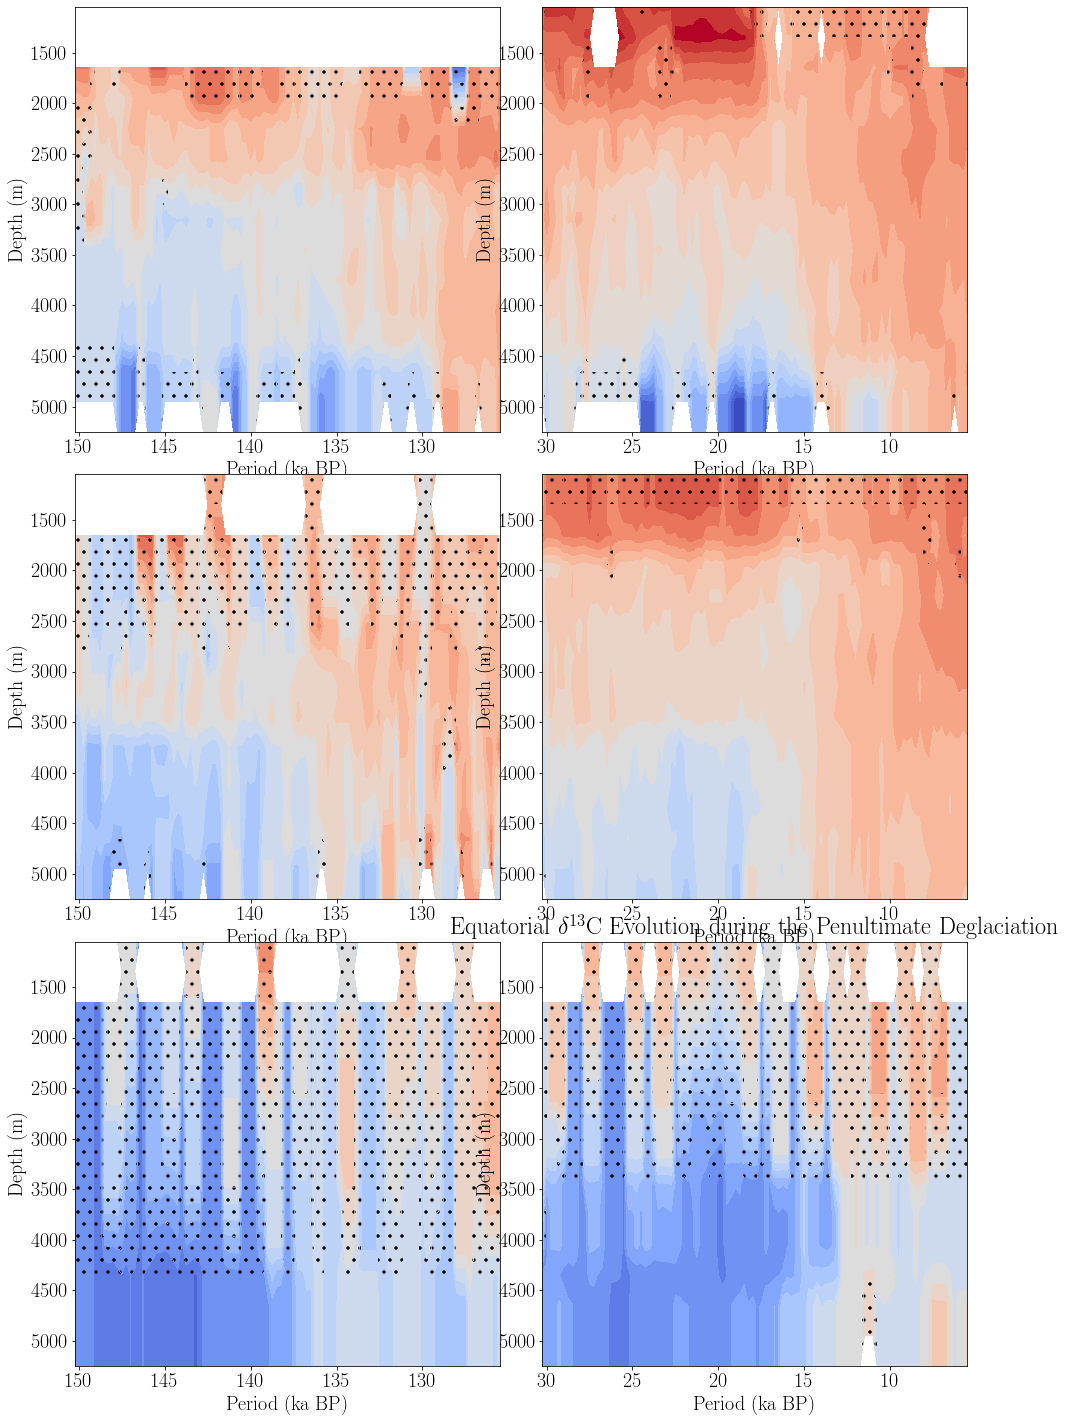

In [9]:
# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[config.loc_list,config.period_list]))).rename(columns={0:'loc',1:'period'})

################################################
                # Set up
################################################

# Set parameters for the graph
cmap = 'coolwarm'
vmin=-1.5
vmax=1.7

# Set up graph
fig = plt.figure(figsize = (16,25))
gs_list = gridspec.GridSpec(len(config.loc_list), len(config.period_list))#,
#                       height_ratios=[height_nth,height_eq,height_sth],width_ratios=[width_hol, width_lig]) 

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

# Loop over all the combinations
for period,loc,gs in zip(combinations.period,combinations['loc'],gs_list):
    
    ax = plt.subplot(gs)
    
    ax = plotting_moving_avg(ax,results_dict,period,loc,vmin,vmax)

ax.set_title('Equatorial $\delta^{13}$C Evolution during the Penultimate Deglaciation')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0.1,hspace=0.1)

plt.show()

In [10]:
gridded_array_interp

<xarray.DataArray (depth: 15, period: 100)>
array([[-0.09555556, -0.08666667, -0.02166667, ...,  0.52      ,
        -0.11      , -0.11      ],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.09555556, -0.08666667, -0.02166667, ...,  0.52      ,
        -0.11      , -0.11      ],
       ...,
       [ 0.215     ,  0.105     ,  0.105     , ..., -0.69833333,
        -0.69833333, -0.81      ],
       [ 0.215     ,  0.105     ,  0.105     , ..., -0.69833333,
        -0.69833333, -0.81      ],
       [ 0.215     ,  0.105     ,  0.105     , ..., -0.69833333,
        -0.69833333, -0.81      ]])
Coordinates:
  * depth    (depth) float64 1.05e+03 1.35e+03 1.65e+03 ... 4.95e+03 5.25e+03
  * period   (period) float64 5.5 5.75 6.0 6.25 6.5 ... 29.5 29.75 30.0 30.25

# Grad analysis

## Calculate Grads

In [11]:

for loc,depth,period,basin in zip(
    combinations['loc'],
    combinations['depth'],
    combinations['period'],
    combinations['basin']
    ):
    
    print(loc)

KeyError: 'depth'

In [ ]:
# Analyse the grads for the shw, dp; nth, sth; Hol and LIG cores

LIG_nth_shw_grad = []
for x1,x2,y1,y2 in zip(LIG_nth_shw_year,[np.nan]+list(LIG_nth_shw_year)[:-1],
                       LIG_nth_shw_d13C,[np.nan]+list(LIG_nth_shw_d13C)[:-1]):
    LIG_nth_shw_grad.append((y1-y2)/(x1-x2))
    
LIG_nth_dp_grad = []
for x1,x2,y1,y2 in zip(LIG_nth_dp_year,[np.nan]+list(LIG_nth_dp_year)[:-1],
                       LIG_nth_dp_d13C,[np.nan]+list(LIG_nth_dp_d13C)[:-1]):
    LIG_nth_dp_grad.append((y1-y2)/(x1-x2))
    
LIG_eq_shw_grad = []
for x1,x2,y1,y2 in zip(LIG_eq_shw_year,[np.nan]+list(LIG_eq_shw_year)[:-1],
                       LIG_eq_shw_d13C,[np.nan]+list(LIG_eq_shw_d13C)[:-1]):
    LIG_eq_shw_grad.append((y1-y2)/(x1-x2))
    
LIG_eq_dp_grad = []
for x1,x2,y1,y2 in zip(LIG_eq_dp_year,[np.nan]+list(LIG_eq_dp_year)[:-1],
                       LIG_eq_dp_d13C,[np.nan]+list(LIG_eq_dp_d13C)[:-1]):
    LIG_eq_dp_grad.append((y1-y2)/(x1-x2))   

LIG_sth_shw_grad = []
for x1,x2,y1,y2 in zip(LIG_sth_shw_year,[np.nan]+list(LIG_sth_shw_year)[:-1],
                       LIG_sth_shw_d13C,[np.nan]+list(LIG_sth_shw_d13C)[:-1]):
    LIG_sth_shw_grad.append((y1-y2)/(x1-x2))
    
LIG_sth_dp_grad = []
for x1,x2,y1,y2 in zip(LIG_sth_dp_year,[np.nan]+list(LIG_sth_dp_year)[:-1],
                       LIG_sth_dp_d13C,[np.nan]+list(LIG_sth_dp_d13C)[:-1]):
    LIG_sth_dp_grad.append((y1-y2)/(x1-x2))
    
Hol_nth_shw_grad = []    
for x1,x2,y1,y2 in zip(Hol_nth_shw_year,[np.nan]+list(Hol_nth_shw_year)[:-1],
                       Hol_nth_shw_d13C,[np.nan]+list(Hol_nth_shw_d13C)[:-1]):
    Hol_nth_shw_grad.append((y1-y2)/(x1-x2))

Hol_nth_dp_grad = []
for x1,x2,y1,y2 in zip(Hol_nth_dp_year,[np.nan]+list(Hol_nth_dp_year)[:-1],
                       Hol_nth_dp_d13C,[np.nan]+list(Hol_nth_dp_d13C)[:-1]):
    Hol_nth_dp_grad.append((y1-y2)/(x1-x2))

Hol_eq_shw_grad = []
for x1,x2,y1,y2 in zip(Hol_eq_shw_year,[np.nan]+list(Hol_eq_shw_year)[:-1],
                       Hol_eq_shw_d13C,[np.nan]+list(Hol_eq_shw_d13C)[:-1]):
    Hol_eq_shw_grad.append((y1-y2)/(x1-x2))

Hol_eq_dp_grad = []
for x1,x2,y1,y2 in zip(Hol_eq_dp_year,[np.nan]+list(Hol_eq_dp_year)[:-1],
                       Hol_eq_dp_d13C,[np.nan]+list(Hol_eq_dp_d13C)[:-1]):
    Hol_eq_dp_grad.append((y1-y2)/(x1-x2))

Hol_sth_shw_grad = []
for x1,x2,y1,y2 in zip(Hol_sth_shw_year,[np.nan]+list(Hol_sth_shw_year)[:-1],
                       Hol_sth_shw_d13C,[np.nan]+list(Hol_sth_shw_d13C)[:-1]):
    Hol_sth_shw_grad.append((y1-y2)/(x1-x2))

Hol_sth_dp_grad = []
for x1,x2,y1,y2 in zip(Hol_sth_dp_year,[np.nan]+list(Hol_sth_dp_year)[:-1],
                       Hol_sth_dp_d13C,[np.nan]+list(Hol_sth_dp_d13C)[:-1]):
    Hol_sth_dp_grad.append((y1-y2)/(x1-x2))
    

In [ ]:
# Store gradients

results_dict.update({
    13 : {'period':"Hol",
    'loc':'nth',
    'dep':'shw',
    'type':'grad',
    'value':tuple(Hol_nth_shw_grad)}
})
results_dict.update({
     14: {'period':"LIG",
    'loc':'nth',
    'dep':'shw',
    'type':'grad',
    'value':tuple(LIG_nth_shw_grad)}
})
results_dict.update({
     15: {'period':"Hol",
    'loc':'eq',
    'dep':'shw',
    'type':'grad',
    'value':tuple(Hol_eq_shw_grad)}
})
results_dict.update({
     16: {'period':"LIG",
    'loc':'eq',
    'dep':'shw',
    'type':'grad',
    'value':tuple(LIG_eq_shw_grad[1:])}
})
results_dict.update({
     17: {'period':"Hol",
    'loc':'sth',
    'dep':'shw',
    'type':'grad',
    'value':tuple(Hol_sth_shw_grad)}
})
results_dict.update({
    18 : {'period':"LIG",
    'loc':'sth',
    'dep':'shw',
    'type':'grad',
    'value':tuple(LIG_sth_shw_grad[:-1])}
})

#########3

results_dict.update({
    19 : {'period':"Hol",
    'loc':'nth',
    'dep':'dp',
    'type':'grad',
    'value':tuple(Hol_nth_dp_grad)}
})
results_dict.update({
    20 : {'period':"LIG",
    'loc':'nth',
    'dep':'dp',
    'type':'grad',
    'value':tuple(LIG_nth_dp_grad)}
})
results_dict.update({
    21 : {'period':"Hol",
    'loc':'eq',
    'dep':'dp',
    'type':'grad',
    'value':tuple(Hol_eq_dp_grad)}
})
results_dict.update({
    22 : {'period':"LIG",
    'loc':'eq',
    'dep':'dp',
    'type':'grad',
    'value':tuple(LIG_eq_dp_grad)}
})
results_dict.update({
     23 : {'period':"Hol",
    'loc':'sth',
    'dep':'dp',
    'type':'grad',
    'value':tuple(Hol_sth_dp_grad)}
})
results_dict.update({
     24: {'period':"LIG",
    'loc':'sth',
    'dep':'dp',
    'type':'grad',
    'value':tuple(LIG_sth_dp_grad)}
})

## Calculate Splines

In [ ]:
# Make splines

from scipy.interpolate import UnivariateSpline as my_smoothing_function

# Order of the cubic spline
k = 5

Hol_nth_shw_smooth = my_smoothing_function(
    Hol_nth_shw_year[1:], Hol_nth_shw_grad[1:],k=k
                                                      )(Hol_nth_shw_year[1:])
LIG_nth_shw_smooth = my_smoothing_function(
    LIG_nth_shw_year[1:], LIG_nth_shw_grad[1:],k=k
                                                      )(LIG_nth_shw_year[1:])
Hol_eq_shw_smooth = my_smoothing_function(
    Hol_eq_shw_year[1:], Hol_eq_shw_grad[1:],k=k
                                                      )(Hol_eq_shw_year[1:])
LIG_eq_shw_smooth = my_smoothing_function(
    LIG_eq_shw_year[2:], LIG_eq_shw_grad[2:],k=k
                                                      )(LIG_eq_shw_year[2:])
Hol_sth_shw_smooth = my_smoothing_function(
    Hol_sth_shw_year[1:], Hol_sth_shw_grad[1:],k=k
                                                      )(Hol_sth_shw_year[1:])
####### this one has nan at the end?
LIG_sth_shw_smooth = my_smoothing_function(
    LIG_sth_shw_year[1:-1], LIG_sth_shw_grad[1:-1],k=k
                                                    )(LIG_sth_shw_year[1:-1])

Hol_nth_dp_smooth = my_smoothing_function(
    Hol_nth_dp_year[1:], Hol_nth_dp_grad[1:],k=k
                                                      )(Hol_nth_dp_year[1:])
LIG_nth_dp_smooth = my_smoothing_function(
    LIG_nth_dp_year[1:], LIG_nth_dp_grad[1:],k=k
                                                      )(LIG_nth_dp_year[1:])
Hol_eq_dp_smooth = my_smoothing_function(
    Hol_eq_dp_year[1:], Hol_eq_dp_grad[1:],k=k
                                                      )(Hol_eq_dp_year[1:])
LIG_eq_dp_smooth = my_smoothing_function(
    LIG_eq_dp_year[1:], LIG_eq_dp_grad[1:],k=k
                                                      )(LIG_eq_dp_year[1:])
Hol_sth_dp_smooth = my_smoothing_function(
    Hol_sth_dp_year[1:], Hol_sth_dp_grad[1:],k=k
                                                      )(Hol_sth_dp_year[1:])
LIG_sth_dp_smooth = my_smoothing_function(
    LIG_sth_dp_year[1:], LIG_sth_dp_grad[1:],k=k
                                                      )(LIG_sth_dp_year[1:])

In [ ]:
# Store the smoothed results

results_dict.update({
    37 : {'period':"Hol",
    'loc':'nth',
    'dep':'shw',
    'type':'smooth',
    'value':tuple(Hol_nth_shw_smooth)}
})
results_dict.update({
     38: {'period':"LIG",
    'loc':'nth',
    'dep':'shw',
    'type':'smooth',
    'value':tuple(LIG_nth_shw_smooth)}
})
results_dict.update({
     39: {'period':"Hol",
    'loc':'eq',
    'dep':'shw',
    'type':'smooth',
    'value':tuple(Hol_eq_shw_smooth)}
})
results_dict.update({
     40: {'period':"LIG",
    'loc':'eq',
    'dep':'shw',
    'type':'smooth',
    'value':tuple(LIG_eq_shw_smooth)}
})
results_dict.update({
     41: {'period':"Hol",
    'loc':'sth',
    'dep':'shw',
    'type':'smooth',
    'value':tuple(Hol_sth_shw_smooth)}
})
results_dict.update({
    42: {'period':"LIG",
    'loc':'sth',
    'dep':'shw',
    'type':'smooth',
    'value':tuple(LIG_sth_shw_smooth)}
})

#########3

results_dict.update({
    43: {'period':"Hol",
    'loc':'nth',
    'dep':'dp',
    'type':'smooth',
    'value':tuple(Hol_nth_dp_smooth)}
})
results_dict.update({
    44: {'period':"LIG",
    'loc':'nth',
    'dep':'dp',
    'type':'smooth',
    'value':tuple(LIG_nth_dp_smooth)}
})
results_dict.update({
    45: {'period':"Hol",
    'loc':'eq',
    'dep':'dp',
    'type':'smooth',
    'value':tuple(Hol_eq_dp_smooth)}
})
results_dict.update({
    46: {'period':"LIG",
    'loc':'eq',
    'dep':'dp',
    'type':'smooth',
    'value':tuple(LIG_eq_dp_smooth)}
})
results_dict.update({
     47: {'period':"Hol",
    'loc':'sth',
    'dep':'dp',
    'type':'smooth',
    'value':tuple(Hol_sth_dp_smooth)}
})
results_dict.update({
     48: {'period':"LIG",
    'loc':'sth',
    'dep':'dp',
    'type':'smooth',
    'value':tuple(LIG_sth_dp_smooth)}
})

## Plot Grads and spline

In [ ]:
# Set up graph

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)
lw = 5 # the width of the smoothed lined

fig = plt.figure(figsize = (16,25))

gs = gridspec.GridSpec(3, 2, height_ratios=[height_nth,height_eq,height_sth],width_ratios=[width_hol, width_lig]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])

########## Plot the raw grads

## Shw cores

ax1.plot(Hol_nth_shw_year, Hol_nth_shw_grad,c=line_color_shw,linestyle='--')
ax1.plot(Hol_nth_shw_year[1:], Hol_nth_shw_smooth,c=line_color_shw,lw=lw)
ax1.plot([np.min(Hol_nth_shw_year),
          np.max(Hol_nth_shw_year)],[0,0],'k--',zorder=-100)

ax2.plot(LIG_nth_shw_year, LIG_nth_shw_grad,c=line_color_shw,linestyle='--')
ax2.plot(LIG_nth_shw_year[1:], LIG_nth_shw_smooth,c=line_color_shw,lw=lw)
ax2.plot([np.min(LIG_nth_shw_year),
          np.max(LIG_nth_shw_year)],[0,0],'k--',zorder=-100)

ax3.plot(Hol_eq_shw_year, Hol_eq_shw_grad,c=line_color_shw,linestyle='--')
ax3.plot(Hol_eq_shw_year[1:], Hol_eq_shw_smooth,c=line_color_shw,lw=lw)
ax3.plot([np.min(Hol_eq_shw_year),
          np.max(Hol_eq_shw_year)],[0,0],'k--',zorder=-100)

ax4.plot(LIG_eq_shw_year, LIG_eq_shw_grad,c=line_color_shw,linestyle='--')
ax4.plot(LIG_eq_shw_year[2:], LIG_eq_shw_smooth,c=line_color_shw,lw=lw)
ax4.plot([np.min(LIG_eq_shw_year),
          np.max(LIG_eq_shw_year)],[0,0],'k--',zorder=-100)

ax5.plot(Hol_sth_shw_year, Hol_sth_shw_grad,c=line_color_shw,linestyle='--')
ax5.plot(Hol_sth_shw_year[1:], Hol_sth_shw_smooth,c=line_color_shw,lw=lw)
ax5.plot([np.min(Hol_sth_shw_year),
          np.max(Hol_sth_shw_year)],[0,0],'k--',zorder=-100)

ax6.plot(LIG_sth_shw_year, LIG_sth_shw_grad,c=line_color_shw,linestyle='--')
ax6.plot(LIG_sth_shw_year[1:-1], LIG_sth_shw_smooth,c=line_color_shw,lw=lw)
ax6.plot([np.min(LIG_sth_shw_year),
          np.max(LIG_sth_shw_year)],[0,0],'k--',zorder=-100)

## Dp cores

ax1.plot(Hol_nth_dp_year, Hol_nth_dp_grad,c=line_color_dp,linestyle='--')
ax1.plot(Hol_nth_dp_year[1:], Hol_nth_dp_smooth,c=line_color_dp,lw=lw)
ax1.plot([np.min(Hol_nth_dp_year),
          np.max(Hol_nth_dp_year)],[0,0],'k--',zorder=-100)

ax2.plot(LIG_nth_dp_year, LIG_nth_dp_grad,c=line_color_dp,linestyle='--')
ax2.plot(LIG_nth_dp_year[1:], LIG_nth_dp_smooth,c=line_color_dp,lw=lw)
ax2.plot([np.min(LIG_nth_dp_year),
          np.max(LIG_nth_dp_year)],[0,0],'k--',zorder=-100)

ax3.plot(Hol_eq_dp_year, Hol_eq_dp_grad,c=line_color_dp,linestyle='--')
ax3.plot(Hol_eq_dp_year[1:], Hol_eq_dp_smooth,c=line_color_dp,lw=lw)
ax3.plot([np.min(Hol_eq_dp_year),
          np.max(Hol_eq_dp_year)],[0,0],'k--',zorder=-100)

ax4.plot(LIG_eq_dp_year, LIG_eq_dp_grad,c=line_color_dp,linestyle='--')
ax4.plot(LIG_eq_dp_year[1:], LIG_eq_dp_smooth,c=line_color_dp,lw=lw)
ax4.plot([np.min(LIG_eq_dp_year),
          np.max(LIG_eq_dp_year)],[0,0],'k--',zorder=-100)

ax5.plot(Hol_sth_dp_year, Hol_sth_dp_grad,c=line_color_dp,linestyle='--')
ax5.plot(Hol_sth_dp_year[1:], Hol_sth_dp_smooth,c=line_color_dp,lw=lw)
ax5.plot([np.min(Hol_sth_dp_year),
          np.max(Hol_sth_dp_year)],[0,0],'k--',zorder=-100)

ax6.plot(LIG_sth_dp_year, LIG_sth_dp_grad,c=line_color_dp,linestyle='--')
ax6.plot(LIG_sth_dp_year[1:], LIG_sth_dp_smooth,c=line_color_dp,lw=lw)
ax6.plot([np.min(LIG_sth_dp_year),
          np.max(LIG_sth_dp_year)],[0,0],'k--',zorder=-100)


# Label Graph

ax1.set_title('Last Deglaciation')
ax2.set_title('Penultimate Deglaciation')

# Plot graph

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0.2,hspace=0)

plt.show()

## Plot spline and difference

In [ ]:
# Conver the results dictionary to a dataframe 

df_results = pd.DataFrame.from_dict(results_dict,orient='index')

In [ ]:
# Set graphic formatting
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

# Define additional variables
lw = 5 # the width of the smoothed lined

# List the different variables that can be combined
period = ["LIG","Hol"]
loc = ['nth','eq','sth']
dep = ['shw','dp']

# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[loc,period,dep]))).rename(columns={0:'loc',1:'period',2:'dep'})

# Set up graph
fig = plt.figure(figsize = (16,25))
gs = gridspec.GridSpec(len(loc), len(period), height_ratios=[height_nth,height_eq,height_sth],width_ratios=[width_hol, width_lig]) 

# Axis counter variable
axc = 0

# Loop over all the combinations
for period,loc,dep in zip(combinations['period'],combinations['loc'],combinations['dep']):

    # Get the axis
    if (axc%1)!=0.5:      
        ax = plt.subplot(gs[int(axc)])
    
    # Go up an axis every second loop
    axc += 0.5
    
    # get only the rows that pertain to this instance
    df_relevant = df_results[(df_results['period']==period) & (df_results['loc']==loc) & (df_results['dep']==dep)]
    
    # plot
#    if not ((period=='LIG')&(dep=='shw')&(loc=='eq')):
    ax.plot(df_relevant[df_relevant['type']=='year'].reset_index()['value'][0][1:],
            df_relevant[df_relevant['type']=='smooth'].reset_index()['value'][0],
            c=[line_color_dp if x=='dp' else line_color_shw for x in [df_relevant.reset_index()['dep'][0]]][0],
            lw=lw)
        
    # Adjust axis
    ax.set_ylim(-0.25,0.3)
    
    # Set y label
    ax.set_ylabel('$\Delta\delta^{13}$C/ka ($\permil$/1000years)')
    
    # Set Hol axis labels to right"
    if (axc%2)!=1:      
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
    else:
        ax.yaxis.set_label_position("left")
        ax.yaxis.tick_left()
        
    # Put labels on graph
    
    if axc==1:
        ax.set_title('Penultimate Deglaciation')
    if axc==2:
        ax.set_title('Last Deglaciation')    
    

# Plot graph

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0,hspace=0)

plt.show()

# d13C Difference plots

In [ ]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

# Define additional variables
lw = 5 # the width of the smoothed lined

# List the different variables that can be combined
period = ["LIG","Hol"]
loc = ['nth','eq','sth']
dep = ['shw','dp']

# Find all possible combinations of period, location and depth
combinations = pd.DataFrame(list(itertools.product(*[loc,period,dep]))).rename(columns={0:'loc',1:'period',2:'dep'})

# Set up graph
fig = plt.figure(figsize = (16,25))
gs = gridspec.GridSpec(len(loc), len(period), height_ratios=[height_nth,height_eq,height_sth],width_ratios=[width_hol, width_lig]) 

# Axis counter variable
axc = 0

# Loop over all the combinations
for period,loc,dep in zip(combinations['period'],combinations['loc'],combinations['dep']):

    # Get the axis
    if (axc%1)!=0.5:      
        ax = plt.subplot(gs[int(axc)])
        
    # Go up an axis every second loop
    axc += 0.5        
    
    # get only the rows that pertain to this instance
    df_relevant = df_results[(df_results['period']==period) & (df_results['loc']==loc) & (df_results['dep']==dep)]
    
    # Store the shallow core results in a dataframe (temporarily, will be overwritten every second loop)
    if dep=='shw':
        df_shw = pd.DataFrame({
            'year':df_relevant[df_relevant['type']=='year'].reset_index()['value'][0],
            'd13C_shw':df_relevant[df_relevant['type']=='d13C'].reset_index()['value'][0]
        })
        
    # Store the deep core results in a dataframe (temporarily, will be overwritten every second loop)
    if dep=='dp':
        df_dp = pd.DataFrame({
            'year':df_relevant[df_relevant['type']=='year'].reset_index()['value'][0],
            'd13C_dp':df_relevant[df_relevant['type']=='d13C'].reset_index()['value'][0]
        })
        
        # Combine the shallow and deep dataframes into one
        df_two_depths = pd.merge(df_shw,df_dp,on='year')

        # Find difference (assuming that you've looked at shallow before deep)
        df_two_depths['diff'] = np.diff(df_two_depths[['d13C_shw','d13C_dp']])
    
        # Plot the difference between the two
        ax.plot(df_two_depths['year'],
        df_two_depths['diff'],
        c='r',
        lw=lw)
                
    # Adjust axis
    ax.set_ylim(-1.25,0.5)
    
    # Set y label
    ax.set_ylabel('$\Delta\delta^{13}$Ca ($\permil$)')    
    
    # For LD axes
    if (axc%2)==0:    
        
        # Set axis labels to right"
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()

        # Plot zero line
        ax.plot([5,30],[0,0],c='k',ls=':',zorder=-100)

    # For PD axes        
    if (axc%2)==1:
        
        # Set axis labels to right"
        ax.yaxis.set_label_position("left")
        ax.yaxis.tick_left()
     
        # Plot zero line
        ax.plot([125,150],[0,0],c='k',ls=':',zorder=-100)        
        
    # Put labels on graph
    
    if axc==1:
        ax.set_title('Penultimate Deglaciation')
    if axc==2:
        ax.set_title('Last Deglaciation')    
    

# Plot graph

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0,hspace=0)

plt.show()

# Replotting Raw data

In [ ]:

fig = plt.figure(figsize=(10,10))

cmap = 'coolwarm'


plt.scatter(interpolated_samples_LIG_Atlantic.age,
            interpolated_samples_LIG_Atlantic.d13C,
            c=interpolated_samples_LIG_Atlantic.Ocean_depth,
            cmap = cmap)

# d13C-depth Evolution through period

In [ ]:
interpolated_samples_LIG_Atl_slice, gridded_array, gridded_array_interp, period_grid, depth_grid = \
    moving_average_slice_array(interpolated_samples_LIG_Atlantic,-30,30)

################################################
                # Set up
################################################

# Set parameters for the graph
cmap = 'coolwarm'

# Set up the graph
plt.figure(figsize = (10,10))
ax = plt.subplot2grid((1,1),(0,0))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)

################################################
                # Plotting points
################################################

# # Show a scatter of the points of the interpolated (with period) d13C moving average
# ax.scatter(interpolated_samples_LIG_Atl_slice.age,
#            interpolated_samples_LIG_Atl_slice.Ocean_depth,
#            c=interpolated_samples_LIG_Atl_slice.d13C,edgecolor='k',
#            cmap=cmap)

################################################
                # Plotting Graph
################################################

# Plot the filled contour of the evolution of NAWD/AABW w/ period and depth
ax.contourf(period_grid,
            depth_grid,
            gridded_array_interp,
            hatches=['.'],
            zorder=-1000,
            cmap=cmap,
            levels=20)

ax.contourf(period_grid,
            depth_grid,
            gridded_array,
            zorder=0,
            cmap=cmap,
            levels=20)

################################################
                # Format the axes
################################################
ax.invert_yaxis()
ax.invert_xaxis()

ax.set_ylabel('Depth (m)')
ax.set_xlabel('Period (ka BP)')

ax.set_title('Equatorial $\delta^{13}$C Evolution during the Penultimate Deglaciation')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}
matplotlib.rc('font', **font)                                                    

plt.subplots_adjust(wspace=0,hspace=0)

plt.show()

In [ ]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : fontsize}
# matplotlib.rc('font', **font)

# # Define additional variables
# lw = 5 # the width of the smoothed lined

# # List the different variables that can be combined
# period = ["LIG","Hol"]
# loc = ['nth','eq','sth']
# dep = ['shw','dp']

# # Find all possible combinations of period, location and depth
# combinations = pd.DataFrame(list(itertools.product(*[loc,period,dep]))).rename(columns={0:'loc',1:'period',2:'dep'})

# # Set up graph
# fig = plt.figure(figsize = (16,25))
# gs = gridspec.GridSpec(len(loc), len(period), height_ratios=[height_nth,height_eq,height_sth],width_ratios=[width_hol, width_lig]) 

# # Axis counter variable
# axc = 0

# # Loop over all the combinations
# for period,loc,dep in zip(combinations['period'],combinations['loc'],combinations['dep']):

#     # Get the axis
#     if (axc%1)!=0.5:      
#         ax = plt.subplot(gs[int(axc)])
        
#     # Go up an axis every second loop
#     axc += 0.5        
    
#     # get only the rows that pertain to this instance
#     df_relevant = df_results[(df_results['period']==period) & (df_results['loc']==loc) & (df_results['dep']==dep)]
    

In [ ]:
df_relevant

In [ ]:

    df_shw = pd.DataFrame({
        'year':df_relevant[df_relevant['type']=='year'].reset_index()['value'][0],
        'd13C_shw':df_relevant[df_relevant['type']=='d13C'].reset_index()['value'][0]
    })
    df_shw = pd.DataFrame({
    'year':df_relevant[df_relevant['type']=='year'].reset_index()['value'][0],
    'd13C_shw':df_relevant[df_relevant['type']=='d13C'].reset_index()['value'][0]
})